In [18]:
from osgeo import gdal
import struct
import numpy as np

In [3]:
!ls ../data/0000543009_001001_ALOS2520970750-240115

BRS-HH-ALOS2520970750-240115-UBSL1.1__A.jpg
IMG-HH-ALOS2520970750-240115-UBSL1.1__A
LED-ALOS2520970750-240115-UBSL1.1__A
TRL-ALOS2520970750-240115-UBSL1.1__A
VOL-ALOS2520970750-240115-UBSL1.1__A
summary.txt


In [35]:
led_file = "../data/0000543009_001001_ALOS2520970750-240115/LED-ALOS2520970750-240115-UBSL1.1__A"

In [37]:
fp_led = open(led_file, mode='rb')

In [63]:
# 校正係数
fp_led.seek(720+4096+4680+16384+20)
cf = fp_led.read(16)
cf

b'     -83.0000000'

In [69]:
# 緯度経度変換係数
fp_led.seek(720+4096+4680+16384+9860+1620+325000+511000+3072+728000+1024)
fp_led.read(2)

b'  '

In [11]:
ceos_file = "../data/0000543009_001001_ALOS2520970750-240115/IMG-HH-ALOS2520970750-240115-UBSL1.1__A"

In [12]:
fp = open(ceos_file, mode='rb')

In [13]:
fp.seek(236)
nline = int(fp.read(8))
print(nline)
fp.seek(248)
npixel = int(fp.read(8))
print(npixel)

32521
23408


In [19]:

fp = open(ceos_file, mode='rb')

col = 2000
row = 2000
cr = np.array([3000,3000+col,8000,8000+row],dtype="i4");

fp.seek(236)
nline = int(fp.read(8))
fp.seek(248)
ncell = int(fp.read(8))
nrec = 544 + ncell*8

nline = cr[3]-cr[2]
fp.seek(720)
fp.read(int((nrec/4)*(cr[2])*4))
data = struct.unpack(">%s"%(int((nrec*nline)/4))+"f",fp.read(int(nrec*nline)))
data = np.array(data).reshape(-1,int(nrec/4))
data = data[:,int(544/4):int(nrec/4)]
slc = data[:,::2] + 1j*data[:,1::2]
slc = slc[:,cr[0]:cr[1]]
print(slc)

[[-159130.5625    -487060.125j       129636.9375    -275020.4375j
   -81984.2265625 -141179.0625j     ...  -46353.37109375 +26898.1171875j
   -18875.29101562 -35962.890625j    -82922.8203125   +3103.32080078j]
 [-309750.40625    -84648.9765625j   -30640.23046875 -79447.828125j
   -29574.58789062-173732.609375j   ...   12607.47753906 +52291.0234375j
    25630.84570312 -19776.45117188j   34040.203125   +17316.30859375j]
 [-104878.5078125 +125638.9453125j  -226249.71875    -22033.59375j
   -61388.015625  -189903.0625j     ...   10518.66699219 +22780.0703125j
    21845.63671875  +5369.60253906j  134373.546875   -51694.41796875j]
 ...
 [  44463.92578125 -11318.98632812j   38879.6484375  +51455.7734375j
  -132167.421875  -107145.515625j   ...   17282.12304688-344149.1875j
   -42342.91796875-301870.59375j     -12985.05371094-256834.578125j  ]
 [ -46856.140625    +3165.3737793j  -105915.8984375  -47582.7109375j
   -79658.78125   -169381.203125j   ...   73873.8203125 -167378.953125j
    48473.3

In [29]:
fp.seek(20)
cf = fp.read(16)

In [34]:
fp.seek(236)
fp.read(8)

b'   32521'

In [31]:
float(cf)

ValueError: could not convert string to float: b'-SAR     A A002.'

In [20]:
slc.shape

(2000, 2000)

In [22]:
slc[0][0]

np.complex128(-159130.5625-487060.125j)

In [41]:
# σ0 = 10*log10 <I2+Q2> + CF -32.0 
sigma = 20*np.log10(abs(slc)) -83.0 -32.0

In [45]:
sigma[0][0]

np.float64(-0.8078780983476008)

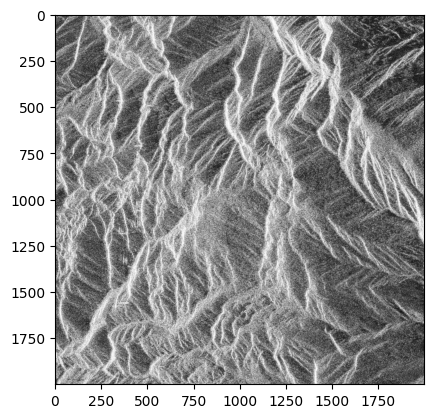

In [46]:
import cv2
import matplotlib.pyplot as plt

sigma = np.array(255*(sigma-np.amin(sigma))/(np.amax(sigma)-np.amin(sigma)),dtype="uint8")
sigma = cv2.equalizeHist(sigma)
plt.figure()
plt.imshow(sigma, cmap = "gray")
plt.imsave('figure.jpg', sigma, cmap = "gray")

In [ ]:
# 等間隔

In [48]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 51.4 MB/s eta 0:00:00a 0:00:01


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [ ]:
# サンプルデータ: 不規則に分布した緯度・経度と対応する値
lats = np.array([34.1, 34.15, 34.2, 34.25, 34.3])
lons = np.array([135.1, 135.15, 135.2, 135.25, 135.3])
values = np.array([10, 15, 20, 25, 30])

# 1. 等間隔の緯度・経度グリッドを定義
lat_grid = np.linspace(min(lats), max(lats), 100)  # 緯度の範囲を100分割
lon_grid = np.linspace(min(lons), max(lons), 100)  # 経度の範囲を100分割

# メッシュグリッドを作成
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# 2. griddataを使って補間
grid_values = griddata(
    points=(lats, lons),         # 入力の緯度・経度（ポイント）
    values=values,              # 入力の値
    xi=(lat_grid, lon_grid),    # 補間対象のグリッド
    method='linear'             # 補間方法（linear, cubic, nearestが利用可能）
)

# 3. 結果を可視化
plt.figure(figsize=(8, 6))
plt.contourf(lon_grid, lat_grid, grid_values, cmap="viridis", levels=50)
plt.colorbar(label="Interpolated Values")
plt.scatter(lons, lats, c=values, color="red", label="Original Data")  # 元データポイント
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Interpolated Data on Regular Grid")
plt.legend()
plt.show()